# **Homework 12 - Reinforcement Learning**

If you have any problem, e-mail us at ntu-ml-2022spring-ta@googlegroups.com



## 前置作業

首先我們需要安裝必要的系統套件及 PyPi 套件。
gym 這個套件由 OpenAI 所提供，是一套用來開發與比較 Reinforcement Learning 演算法的工具包（toolkit）。
而其餘套件則是為了在 Notebook 中繪圖所需要的套件。

In [1]:
# !apt update
# !apt install python-opengl xvfb -y
# !pip install gym[box2d]==0.18.3 pyvirtualdisplay tqdm


接下來，設置好 virtual display，並引入所有必要的套件。

In [2]:
%%capture
from pyvirtualdisplay import Display
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

%matplotlib inline
import matplotlib.pyplot as plt

from IPython import display

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
from tqdm.notebook import tqdm

import inspect


最後，引入 OpenAI 的 gym，並建立一個 [Lunar Lander](https://gym.openai.com/envs/LunarLander-v2/) 環境。

In [3]:
from utils import fix
seed = 543
lines = inspect.getsource(fix)
print(lines)

def fix(env, seed):
    # Python built-in random module
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Torch
    torch.manual_seed(seed)
    # Gym
    env.seed(seed)
    env.action_space.seed(seed)
    
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True



In [4]:
%%capture
import gym
# import random
env = gym.make('LunarLander-v2')
fix(env, seed) # fix the environment Do not revise this !!!

## 什麼是 Lunar Lander？

“LunarLander-v2” 這個環境是在模擬登月小艇降落在月球表面時的情形。
這個任務的目標是讓登月小艇「安全地」降落在兩個黃色旗幟間的平地上。
> Landing pad is always at coordinates (0,0).
> Coordinates are the first two numbers in state vector.

![](https://gym.openai.com/assets/docs/aeloop-138c89d44114492fd02822303e6b4b07213010bb14ca5856d2d49d6b62d88e53.svg)

所謂的「環境」其實同時包括了 agent 和 environment。
我們利用 `step()` 這個函式讓 agent 行動，而後函式便會回傳 environment 給予的 observation/state（以下這兩個名詞代表同樣的意思）和 reward。

Last, call gym and build an [Lunar Lander](https://gym.openai.com/envs/LunarLander-v2/) environment.

### Observation / State

首先，我們可以看看 environment 回傳給 agent 的 observation 究竟是長什麼樣子的資料：

In [5]:
print(env.observation_space)

Box(-inf, inf, (8,), float32)


`Box(8,)` 說明我們會拿到 8 維的向量作為 observation，其中包含：垂直及水平座標、速度、角度、加速度等等，這部分我們就不細說。

### Action

而在 agent 得到 observation 和 reward 以後，能夠採取的動作有：

In [6]:
print(env.action_space)

Discrete(4)


`Discrete(4)` 說明 agent 可以採取四種離散的行動：
- 0 代表不採取任何行動
- 2 代表主引擎向下噴射
- 1, 3 則是向左右噴射

接下來，我們嘗試讓 agent 與 environment 互動。
在進行任何操作前，建議先呼叫 `reset()` 函式讓整個「環境」重置。
而這個函式同時會回傳「環境」最初始的狀態。

In [7]:
initial_state = env.reset()
print(initial_state)

[ 0.00396109  1.4083536   0.40119505 -0.11407257 -0.00458307 -0.09087662
  0.          0.        ]


接著，我們試著從 agent 的四種行動空間中，隨機採取一個行動

In [8]:
random_action = env.action_space.sample()
print(random_action)

0


再利用 `step()` 函式讓 agent 根據我們隨機抽樣出來的 `random_action` 動作。
而這個函式會回傳四項資訊：
- observation / state
- reward
- 完成與否
- 其餘資訊

In [9]:
observation, reward, done, info = env.step(random_action)

第一項資訊 `observation` 即為 agent 採取行動之後，agent 對於環境的 observation 或者說環境的 state 為何。
而第三項資訊 `done` 則是 `True` 或 `False` 的布林值，當登月小艇成功著陸或是不幸墜毀時，代表這個回合（episode）也就跟著結束了，此時 `step()` 函式便會回傳 `done = True`，而在那之前，`done` 則保持 `False`。

In [10]:
print(done)

False


### Reward

而「環境」給予的 reward 大致是這樣計算：
- 小艇墜毀得到 -100 分
- 小艇在黃旗幟之間成功著地則得 100~140 分
- 噴射主引擎（向下噴火）每次 -0.3 分
- 小艇最終完全靜止則再得 100 分

> Reward for moving from the top of the screen to landing pad and zero speed is about 100..140 points.
> If lander moves away from landing pad it loses reward back.
> Episode finishes if the lander crashes or comes to rest, receiving additional -100 or +100 points.
> Each leg ground contact is +10.
> Firing main engine is -0.3 points each frame.
> Solved is 200 points.

In [11]:
print(reward)

-0.8588900517154912


### Random Agent

最後，在進入實做之前，我們就來看看這樣一個 random agent 能否成功登陸月球：

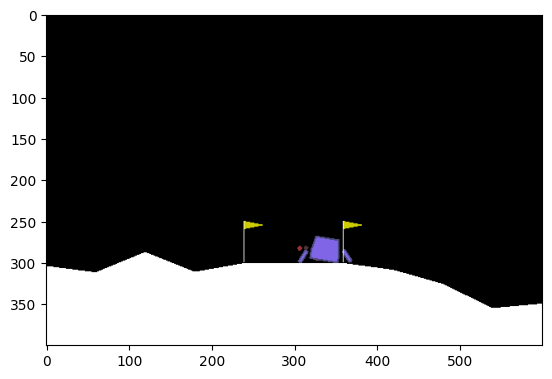

In [12]:
env.reset()

img = plt.imshow(env.render(mode='rgb_array'))

done = False
while not done:
    action = env.action_space.sample()
    observation, reward, done, _ = env.step(action)

    img.set_data(env.render(mode='rgb_array'))
    display.display(plt.gcf())
    display.clear_output(wait=True)

## Policy Gradient

現在來搭建一個簡單的 policy network。
我們預設模型的輸入是 8-dim 的 observation，輸出則是離散的四個動作之一：
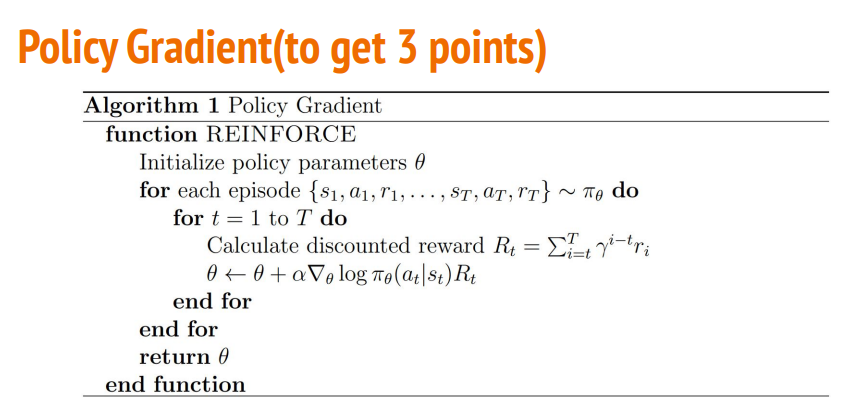

In [13]:
from model import PolicyGradientNetwork
lines = inspect.getsource(PolicyGradientNetwork)
print(lines)

class PolicyGradientNetwork(nn.Module):

    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(8, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 4)

    def forward(self, state):
        hid = torch.tanh(self.fc1(state))
        hid = torch.tanh(self.fc2(hid))
        return F.softmax(self.fc3(hid), dim=-1)



再來，搭建一個簡單的 agent，並搭配上方的 policy network 來採取行動。
這個 agent 能做到以下幾件事：
- `learn()`：從記下來的 log probabilities 及 rewards 來更新 policy network。
- `sample()`：從 environment 得到 observation 之後，利用 policy network 得出應該採取的行動。
而此函式除了回傳抽樣出來的 action，也會回傳此次抽樣的 log probabilities。

In [14]:
from torch.optim.lr_scheduler import StepLR    
    
from model import PolicyGradientAgent
lines = inspect.getsource(PolicyGradientAgent)
print(lines)    

class PolicyGradientAgent():
    
    def __init__(self, network):
        self.network = network
        self.optimizer = optim.SGD(self.network.parameters(), lr=0.001)
        
    def forward(self, state):
        return self.network(state)
    
    def learn(self, log_probs, rewards):
        loss = (-log_probs * rewards.to(device)).sum() # You don't need to revise this to pass simple baseline (but you can)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()   
            
    def sample(self, state):
        action_prob = self.network(torch.FloatTensor(state).to(device))
        action_dist = Categorical(action_prob)
        action = action_dist.sample()
        log_prob = action_dist.log_prob(action)
        return action.item(), log_prob



最後，建立一個 network 和 agent，就可以開始進行訓練了。

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"
network = PolicyGradientNetwork().to(device)
agent = PolicyGradientAgent(network)

## Actor Critic
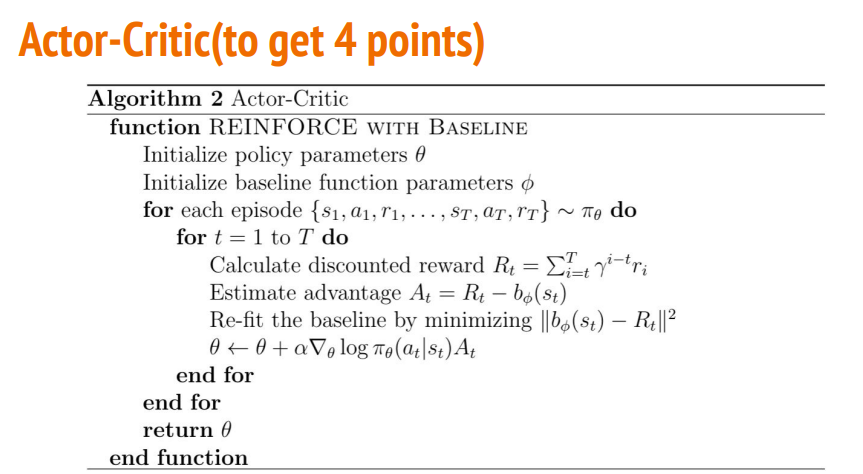

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"  

from actor_critic import sharedNetwork, actorCritic

lines = inspect.getsource(sharedNetwork)
print(lines)

lines = inspect.getsource(actorCritic)
print(lines)


network = sharedNetwork().to(device)
agent = actorCritic(network)

class sharedNetwork(nn.Module):
    def __init__(self):
        super(sharedNetwork, self).__init__()
        # Shared FC
        self.sfc1 = nn.Linear(8, 16)
        self.sfc2 = nn.Linear(16, 32)
        self.sfc3 = nn.Linear(32, 32)

        # Actor FC
        self.actorfc1 = nn.Linear(32, 16)
        self.actorfc2 = nn.Linear(16, 4)
        # Critic FC
        self.criticfc1 = nn.Linear(32, 8)
        self.criticfc2 = nn.Linear(8, 1)

        self.relu = nn.LeakyReLU()
    
    def forward1(self, input):
        x = self.relu(self.sfc1(input))
        x = self.relu(self.sfc2(x))
        x = self.relu(self.sfc3(x))
        x = self.relu(self.actorfc1(x))
        return F.softmax(self.actorfc2(x), dim=-1)

    def forward2(self, input):
        x = self.relu(self.sfc1(input))
        x = self.relu(self.sfc2(x))
        x = self.relu(self.sfc3(x))
        x = self.relu(self.criticfc1(x))
        return self.criticfc2(x)

class actorCritic():
    def __init__(self, network):
        sel

/home/leyan/anaconda3/envs/torch_1_21/lib/python3.8/site-packages/torch/optim/sgd.py:105: UserWarning: optimizer contains a parameter group with duplicate parameters; in future, this will cause an error; see github.com/pytorch/pytorch/issues/40967 for more information
  super(SGD, self).__init__(params, defaults)


## 訓練 Agent

現在我們開始訓練 agent。
透過讓 agent 和 environment 互動，我們記住每一組對應的 log probabilities 及 reward，並在成功登陸或者不幸墜毀後，回放這些「記憶」來訓練 policy network。

In [17]:
from script_actor_critic import train
lines = inspect.getsource(train)
print(lines)    

def train(env, agent, avg_total_rewards, avg_final_rewards, EPISODE_PER_BATCH, NUM_BATCH, GAMMA):
    agent.network.train()  # 訓練前，先確保 network 處在 training 模式
    prg_bar = tqdm(range(NUM_BATCH))
    for batch in prg_bar:

        log_probs, rewards, advantages = [], [], []
        total_rewards, final_rewards = [], []
        
        # collect trajectory 蒐集訓練資料
        for episode in range(EPISODE_PER_BATCH):
            
            state = env.reset()
            total_reward, total_step = 0, 0
            seq_rewards = []
            while True:

                action, log_prob = agent.sample(state) # at, log(at|st)
                next_state, reward, done, _ = env.step(action)

                log_probs.append(log_prob) # [log(a1|s1), log(a2|s2), ...., log(at|st)]
                # seq_rewards.append(reward)
                state = next_state # s_t
                total_reward += reward
                total_step += 1
                rewards.append(reward) # change here
         

In [18]:
EPISODE_PER_BATCH = 5  # 每蒐集 5 個 episodes 更新一次 agent
NUM_BATCH = 1000       # 總共更新 400 次
GAMMA = 0.99           # Dacay rate

avg_total_rewards, avg_final_rewards = [], []

train(env, agent, avg_total_rewards, avg_final_rewards, EPISODE_PER_BATCH, NUM_BATCH, GAMMA)

  0%|          | 0/1000 [00:00<?, ?it/s]

### Medium - accumulative rewards
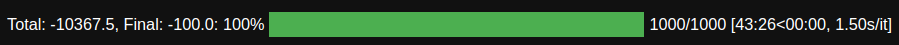
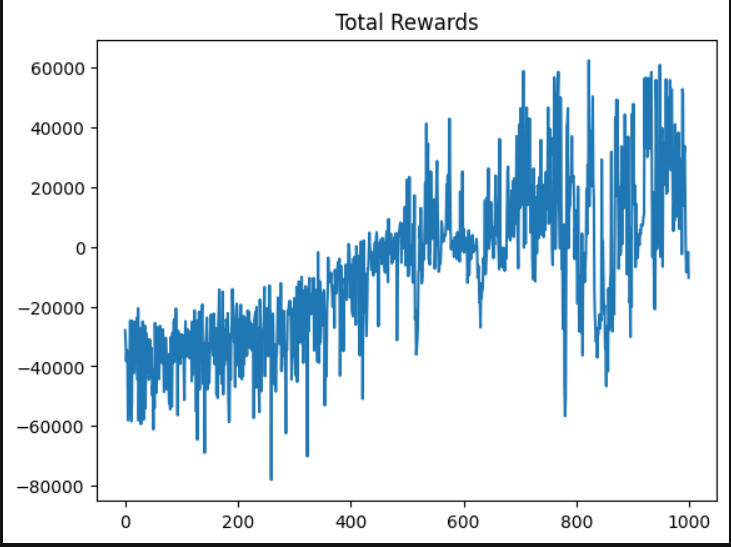
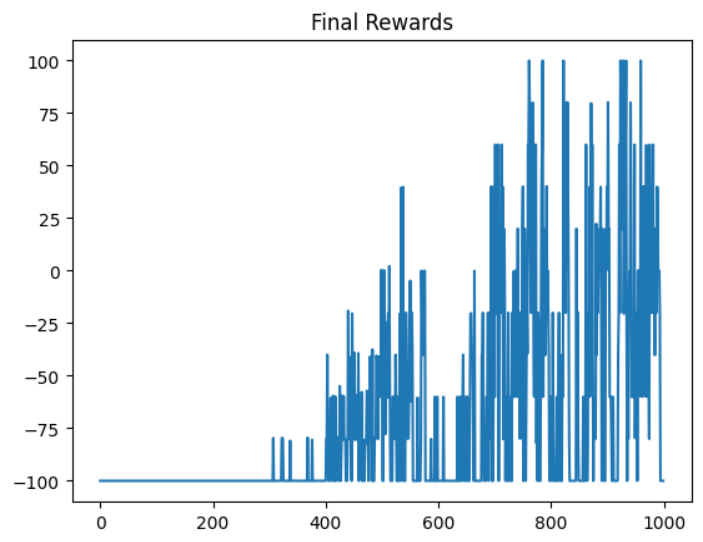

### Boss - Actor Critic

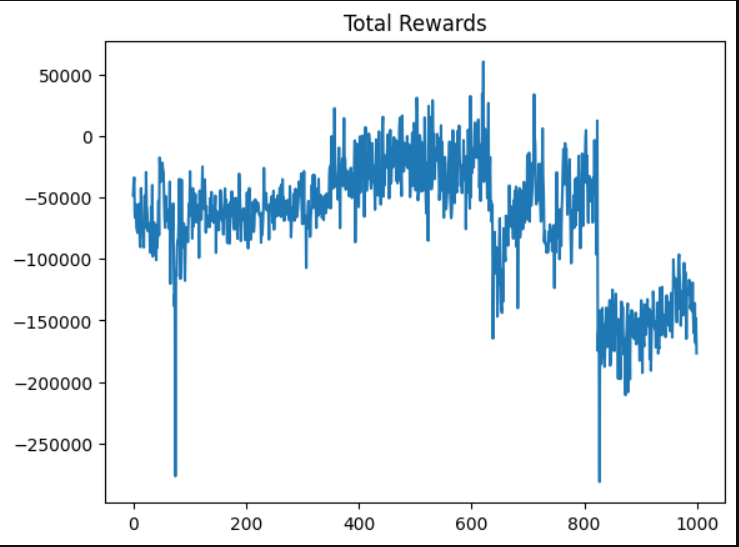
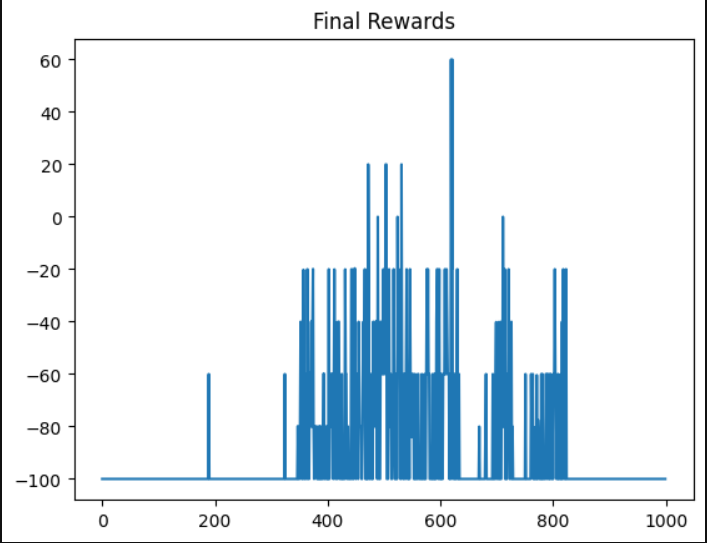

# DQN
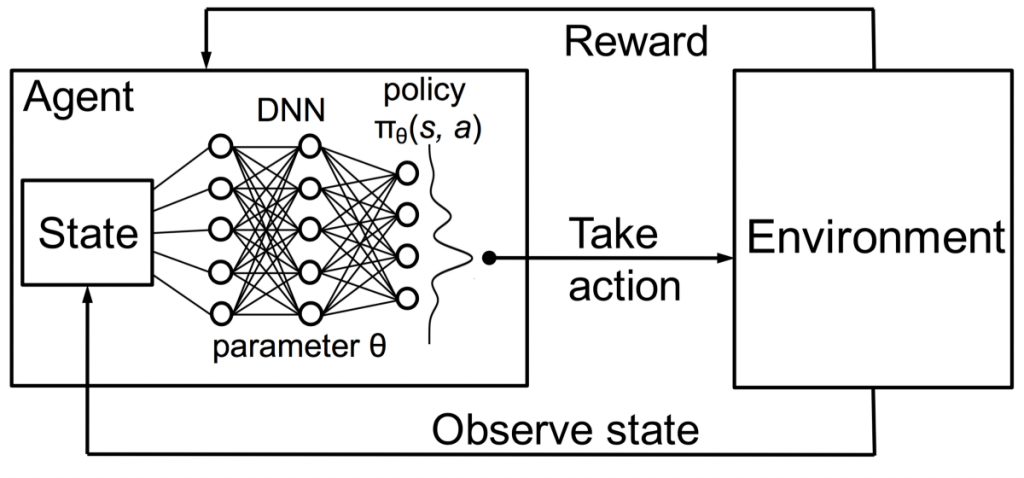

In [19]:
from dqn import Action, Critic, DQN
lines = inspect.getsource(Action)
print(lines)   

lines = inspect.getsource(Critic)
print(lines)  

lines = inspect.getsource(DQN)
print(lines)  

class Action(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(8, 64)
    self.fc2 = nn.Linear(64, 64)
    self.fc3 = nn.Linear(64, 4)

  def forward(self, state):
      hid = torch.tanh(self.fc1(state))
      hid = torch.tanh(self.fc2(hid))
      return F.softmax(self.fc3(hid), dim=-1)

class Critic(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(8, 64)
    self.fc2 = nn.Linear(64, 64)
    self.fc3 = nn.Linear(64, 4)

  def forward(self, state):
      hid = torch.tanh(self.fc1(state))
      hid = torch.tanh(self.fc2(hid))
      return F.softmax(self.fc3(hid), dim=-1)

class DQN():
    def __init__(self,action,critic):
        self.action_net = action
        self.critic_net = critic
        self.optimizer = optim.Adam(self.action_net.parameters(), lr=5e-4)
        self.critic_net.load_state_dict(self.action_net.state_dict()) # 加载action_net的行为
        self.critic_net.eval() # 模型验证

    def forward(self, state):
        r

In [20]:
from script_dqn import train
lines = inspect.getsource(train)
print(lines) 

def train(env, agent, avg_total_rewards, avg_final_rewards, EPISODE_PER_BATCH, NUM_BATCH, GAMMA):
    agent.action_net.train()  # 訓練前，先確保 network 處在 training 模式
    prg_bar = tqdm(range(NUM_BATCH))
    for batch in prg_bar:
        state_action_values, expected_state_action_values = [], []
        total_rewards, final_rewards = [], []
        # 收集訓練資料
        for episode in range(EPISODE_PER_BATCH):
            state = env.reset()
            total_reward = 0
            while True:
                action = agent.sample(state)
                next_state, reward, done, _ = env.step(action)
                state_action_value = agent.action_net(torch.FloatTensor(state).to(device))[action]
                state_action_values.append(state_action_value.to(device))
                state = next_state
                #Double DQN
                if done:
                    next_state_value = 0
                else:
                    next_state_value = agent.critic_net(torch.FloatTensor(state)

In [21]:
# action = Action().to(device)
# critic = Critic().to(device)
# agent = DQN(action, critic)

# EPISODE_PER_BATCH = 10  # 每收集五個episodes 更新一次 agent
# NUM_BATCH = 1000        # 一共更新400次
# avg_total_rewards, avg_final_rewards = [], []

# train(env, agent, avg_total_rewards, avg_final_rewards, EPISODE_PER_BATCH, NUM_BATCH, GAMMA)

### DQN - num400
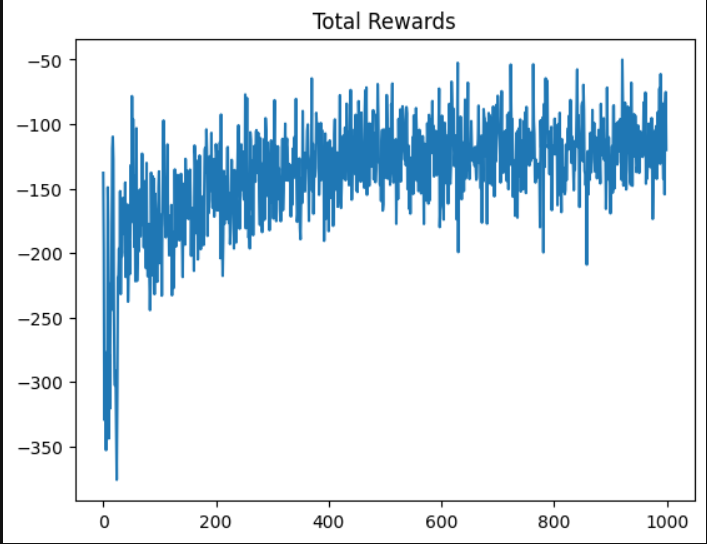
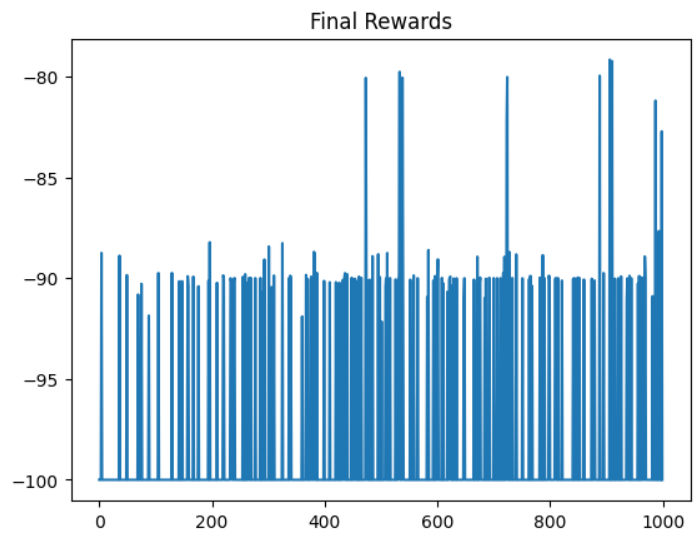

### 訓練結果

訓練過程中，我們持續記下了 `avg_total_reward`，這個數值代表的是：每次更新 policy network 前，我們讓 agent 玩數個回合（episodes），而這些回合的平均 total rewards 為何。
理論上，若是 agent 一直在進步，則所得到的 `avg_total_reward` 也會持續上升，直至 250 上下。
若將其畫出來則結果如下：

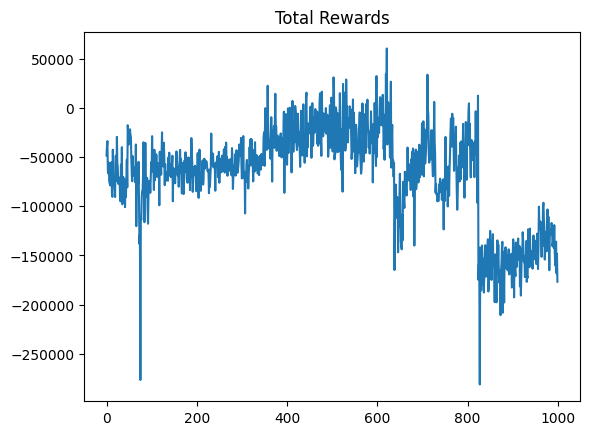

In [22]:
plt.plot(avg_total_rewards)
plt.title("Total Rewards")
plt.show()

另外，`avg_final_reward` 代表的是多個回合的平均 final rewards，而 final reward 即是 agent 在單一回合中拿到的最後一個 reward。
如果同學們還記得環境給予登月小艇 reward 的方式，便會知道，不論**回合的最後**小艇是不幸墜毀、飛出畫面、或是靜止在地面上，都會受到額外地獎勵或處罰。
也因此，final reward 可被用來觀察 agent 的「著地」是否順利等資訊。

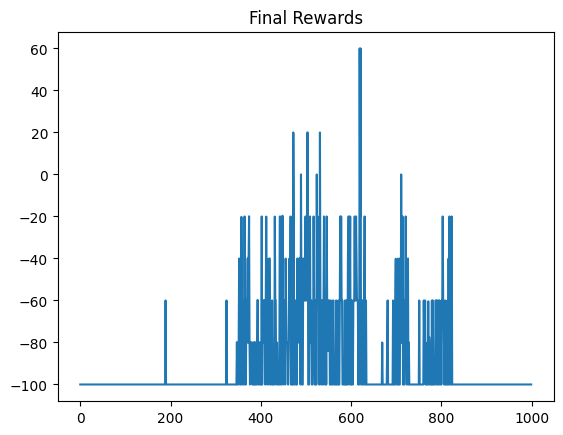

In [23]:
plt.plot(avg_final_rewards)
plt.title("Final Rewards")
plt.show()

## 測試

In [24]:
from script import test
lines = inspect.getsource(test)
print(lines)  

def test(env, agent, NUM_OF_TEST):      
    # fix(env, seed)
    agent.network.eval()    # 測試前先將 network 切換為 evaluation 模式
    # NUM_OF_TEST = 5 # Do not revise this !!!
    test_total_reward = []
    action_list = []
    for i in range(NUM_OF_TEST):
        actions = []
        state = env.reset()

        img = plt.imshow(env.render(mode='rgb_array'))

        total_reward = 0

        done = False
        while not done:
                action, _ = agent.sample(state)
                actions.append(action)
                state, reward, done, _ = env.step(action)

                total_reward += reward

                img.set_data(env.render(mode='rgb_array'))
                display.display(plt.gcf())
                display.clear_output(wait=True)
                
        print(total_reward)
        test_total_reward.append(total_reward)

        action_list.append(actions) # save the result of testing 

    return test_total_reward, action_list



-745.3436943578745


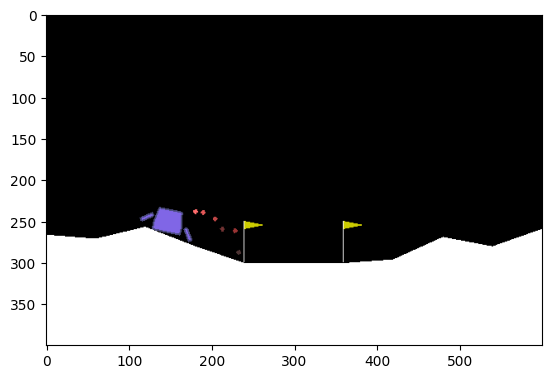

In [31]:
fix(env, seed)
NUM_OF_TEST = 5 # Do not revise this !!!
test_total_reward, action_list = test(env, agent, NUM_OF_TEST)

In [26]:
print(np.mean(test_total_reward))

-674.6829028794277


Action list

In [27]:
print("Action list looks like ", action_list)
print("Action list's shape looks like ", np.shape(action_list))

Action list looks like  [[1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 1, 2, 2, 1, 1, 2, 2, 1, 2, 1, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

/home/leyan/anaconda3/envs/torch_1_21/lib/python3.8/site-packages/numpy/core/fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


Analysis of actions taken by agent

In [28]:
distribution = {}
for actions in action_list:
    for action in actions:
        if action not in distribution.keys():
            distribution[action] = 1
        else:
            distribution[action] += 1
print(distribution)

{1: 365, 2: 71}


Saving the result of Model Testing

In [29]:
PATH = "Action_List.npy" # Can be modified into the name or path you want
np.save(PATH ,np.array(action_list)) 

/tmp/ipykernel_14812/1616289779.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.save(PATH ,np.array(action_list))


# Server 
The code below simulate the environment on the judge server. Can be used for testing.

Your reward is : -673.73
Your reward is : -816.29
Your reward is : -598.56
Your reward is : -539.49
Your reward is : -745.34


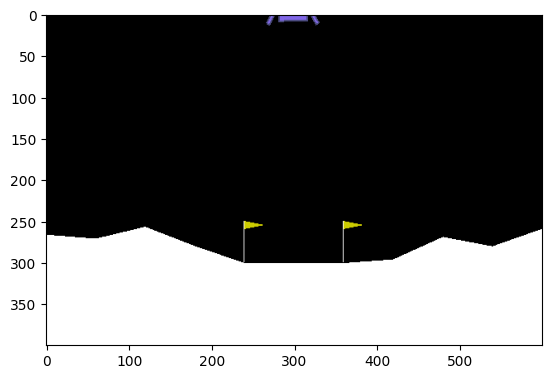

In [32]:
action_list = np.load(PATH,allow_pickle=True) # The action list you upload
seed = 543 # Do not revise this
fix(env, seed)

agent.network.eval()    # set network to evaluation mode
# agent.action_net.eval()    # set network to evaluation mode (DQN)

test_total_reward = []
if len(action_list) != 5:
    print("Wrong format of file !!!")
    exit(0)
for actions in action_list:
    state = env.reset()
    img = plt.imshow(env.render(mode='rgb_array'))

    total_reward = 0

    done = False

    for action in actions:
    
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break

    print(f"Your reward is : %.2f"%total_reward)
    test_total_reward.append(total_reward)

# Your score

In [33]:
print(f"Your final reward is : %.2f"%np.mean(test_total_reward))

Your final reward is : -674.68


## 參考資料

以下是一些有用的參考資料。
建議同學們實做前，可以先參考第一則連結的上課影片。
在影片的最後有提到兩個有用的 Tips，這對於本次作業的實做非常有幫助。

- [DRL Lecture 1: Policy Gradient (Review)](https://youtu.be/z95ZYgPgXOY)
- [ML Lecture 23-3: Reinforcement Learning (including Q-learning) start at 30:00](https://youtu.be/2-JNBzCq77c?t=1800)
- [Lecture 7: Policy Gradient, David Silver](http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching_files/pg.pdf)
